In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import minimize

In [24]:
def displayData(X):
    num_plots=int(np.size(X,0)**.5)
    fig,ax=plt.subplots(num_plots,num_plots,sharex=True,sharey=True)
    img_num=0
    for i in range(num_plots):
        for j in range(num_plots):
            img=X[img_num,:].reshape(20,20).T #converting column vector to 20X 20 pixel matrix to show image
            ax[i][j].imshow(img,cmap="gray")
            
            img_num+=1
    return (fig,ax)

In [3]:
def displayImage(im):
    fig2,ax2=plt.subplots()
    image=im.reshape(20,20).T
    ax2=imshow(image,camp="gray")

In [4]:
def sigmoid(z):
    return 1/(1+np.e**(-z))

In [34]:
def sigmoidGradient(z):
    return (sigmoid(z)*(1-sigmoid(z)))

In [45]:
def predict(theta1,theta2,X):
    m = len(X) 

    if np.ndim(X) == 1:
        X = X.reshape((-1,1))
    
    D1 = np.hstack((np.ones((m,1)),X))# add column of ones
   
    #  hidden layer
    hidden_pred = np.dot(D1,theta1.T) # (5000 x 401) x (401 x 25) = 5000 x 25
    
    # Add column of ones 
    ones = np.ones((len(hidden_pred),1)) # 5000 x 1
    hidden_pred = sigmoid(hidden_pred)
    hidden_pred = np.hstack((ones,hidden_pred)) # 5000 x 26
    
    #output layer 
    output_pred = np.dot(hidden_pred,theta2.T) # (5000 x 26) x (26 x 10)    
    output_pred = sigmoid(output_pred)
    # Get predictions
    p = np.argmax(output_pred,axis=1)
    
    return p

In [40]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels,
                   X,y,reg_param):
    """
    Computes loss using sum of square errors for a neural network
    using theta as the parameter vector for linear regression to fit 
    the data points in X and y with penalty reg_param.
    """
    m = len(y)    
    # Reshape nn_params back into neural network
    theta1 = nn_params[:(hidden_layer_size * (input_layer_size + 1))].reshape((hidden_layer_size, input_layer_size +1))
  
    theta2 = nn_params[-((hidden_layer_size + 1) * 
                          num_labels):].reshape((num_labels,
                    hidden_layer_size + 1))
   
    # Turn scalar y values into a matrix of binary 
    init_y = np.zeros((m,num_labels)) # 5000 x 10
 
    for i in range(m):
        init_y[i][y[i]] = 1

    # Add column of ones to X
    ones = np.ones((m,1)) 
    d = np.hstack((ones,X))# add column of ones
 
    # forward propogation with theta1 and theta2
    cost = [0]*m
    # Initalize gradient vector
    D1 = np.zeros_like(theta1)
    D2 = np.zeros_like(theta2)
    for i in range(m):

        a1 = d[i][:,None] # 401 x 1
        z2 = np.dot(theta1,a1) # 25 x 1 
        a2 = sigmoid(z2) # 25 x 1
        a2 = np.vstack((np.ones(1),a2)) # 26 x 1
        z3 = np.dot(theta2,a2) #10 x 1
        h = sigmoid(z3) # 10 x 1
        a3 = h # 10 x 1
        cost[i] = (np.sum((-init_y[i][:,None])*(np.log(h)) - (1-init_y[i][:,None])*(np.log(1-h))))/m

# Calculate Gradient
        d3 = a3 - init_y[i][:,None]
        d2 = np.dot(theta2.T,d3)[1:]*(sigmoidGradient(z2))
        # Accumulate errors for gradient calculation
        D1 = D1 + np.dot(d2,a1.T) # 25 x 401 (matches theta0)
        D2 = D2 + np.dot(d3,a2.T) # 10 x 26 (matches theta1)

    # regularization
    reg = (reg_param/(2*m))*((np.sum(theta1[:,1:]**2)) +  (np.sum(theta2[:,1:]**2)))
    
    # Compute final gradient with regularization
    grad1 = (1.0/m)*D1 + (reg_param/m)*theta1
    grad1[0] = grad1[0] - (reg_param/m)*theta1[0]
    
    grad2 = (1.0/m)*D2 + (reg_param/m)*theta2
    grad2[0] = grad2[0] - (reg_param/m)*theta2[0]
    
    # Append and unroll gradient
    grad = np.append(grad1,grad2).reshape(-1)
    final_cost = sum(cost) + reg

    return (final_cost, grad)

In [10]:
def randInitializeWeights(L_in,L_out):
    randWeights=np.random.uniform(low=-.12,high=.12,size=(L_in,L_out))
    return randWeights

In [11]:
def debugInitializeWeights(fan_in, fan_out):
    """
    Initializes the weights of a layer with fan_in incoming connections and
    fan_out outgoing connections using a fixed set of values.
    """
    
    # Set W to zero matrix
    W = np.zeros((fan_out,fan_in + 1))

    # Initialize W using "sin". This ensures that W is always of the same
    # values and will be useful in debugging.
    W = np.array([np.sin(w) for w in 
                 range(np.size(W))]).reshape((np.size(W,0),np.size(W,1)))
    
    return W

In [12]:
def computeNumericalGradient(J,theta):
    """
    Computes the gradient of J around theta using finite differences and 
    yields a numerical estimate of the gradient.
    """
    
    numgrad = np.zeros_like(theta)
    perturb = np.zeros_like(theta)
    tol = 1e-4
    
    for p in range(len(theta)):
        # Set perturbation vector
        perturb[p] = tol
        loss1 = J(theta - perturb)
        loss2 = J(theta + perturb)

        # Compute numerical gradient
        numgrad[p] = (loss2 - loss1)/(2 * tol)
        perturb[p] = 0

    return numgrad

In [36]:
def checkNNGradients(reg_param):
    """
    Creates a small neural network to check the back propogation gradients.
    Outputs the analytical gradients produced by the back prop code and the
    numerical gradients computed using the computeNumericalGradient function.
    These should result in very similar values.
    """
    # Set up small NN
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # Generate some random test data
    Theta1 = debugInitializeWeights(hidden_layer_size,input_layer_size)
    Theta2 = debugInitializeWeights(num_labels,hidden_layer_size)

    # Reusing debugInitializeWeights to get random X
    X = debugInitializeWeights(input_layer_size - 1, m)

    # Set each element of y to be in [0,num_labels]
    y = [(i % num_labels) for i in range(m)]

    # Unroll parameters
    nn_params = np.append(Theta1,Theta2).reshape(-1)

    # Compute Cost
    cost, grad = nnCostFunction(nn_params,
                                input_layer_size,hidden_layer_size,num_labels,
                                X, y, reg_param)
    return (cost,grad)

In [31]:
def reduced_cost_func(p):
        """ Cheaply decorated nnCostFunction """
        return nnCostFunction(p,input_layer_size,hidden_layer_size,num_labels,X,y,reg_param)[0]

    

Loading training data...


/home/kalyan/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Loading neural network parameters 

Checking cost function without regularization...
Checking cost function with regularization...
Checking sigmoid gradient...
Initializing neural network parameters...
The initial cost after random initialization:  7.106812701318774
         Current function value: 0.697008
         Iterations: 50
         Function evaluations: 109
         Gradient evaluations: 109
Training Accuracy with neural network:  95.62 %


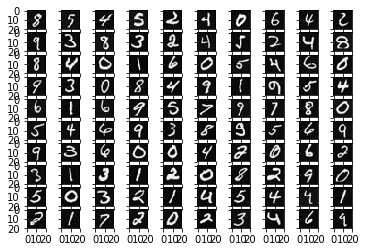

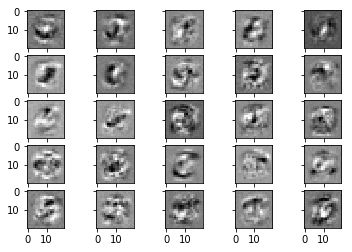

In [46]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

print("Loading training data...")

raw_mat = scipy.io.loadmat("ex4data1.mat")
X = raw_mat.get("X")
y = raw_mat.get("y").flatten()
y = (y - 1) % 10 # ex3 way of converting MATLAB 1-indexing

# Randomly select 100 datapoints to display
rand_indices = np.random.randint(0,len(X),100)
sel = X[rand_indices,:] 

digit_grid, ax = displayData(sel)
digit_grid.show()

print("Loading neural network parameters \n")

raw_params = scipy.io.loadmat("ex4weights.mat")
theta1 = raw_params.get("Theta1") # 25 x 401
theta2 = raw_params.get("Theta2") # 10 x 26

# Unroll Parameters
nn_params = np.append(theta1,theta2).reshape(-1)

print("Checking cost function without regularization...")
reg_param = 0.0
cost, g = nnCostFunction(nn_params,input_layer_size,hidden_layer_size,num_labels, X,y,reg_param)
# Test for correct cost
np.testing.assert_almost_equal(0.287629,cost,decimal=6, err_msg="Cost incorrect.")

# Regularized 
print("Checking cost function with regularization...")
reg_param = 1.0
reg_cost, g = nnCostFunction(nn_params,input_layer_size,hidden_layer_size,num_labels,
                      X,y,reg_param)
np.testing.assert_almost_equal(0.383770,reg_cost,decimal=6, 
                               err_msg="Regularized Cost incorrect.")

print("Checking sigmoid gradient...")
vals = np.array([1,-0.5,0,0.5,1])
g = sigmoidGradient(vals)
np.testing.assert_almost_equal(0.25, g[2],decimal=2, err_msg="Sigmoid function incorrect")

# Initialize neural network parameters
print("Initializing neural network parameters...")
initial_theta1 = randInitializeWeights(input_layer_size+1,hidden_layer_size)
initial_theta2 = randInitializeWeights(hidden_layer_size+1,num_labels)

# Unroll 
initial_nn_params = np.append(initial_theta1,initial_theta2).reshape(-1)

reg_param = 0.0
initial_cost, g = nnCostFunction(initial_nn_params,input_layer_size,
                                 hidden_layer_size,num_labels,X,y,reg_param)

print("The initial cost after random initialization: ", initial_cost)

# Check gradients
checkNNGradients(0)

# TO FIX: Gradient checking with non-zero regularization parameter fails  ?
# Implement Regularization
# punisher = 3.0
# checkNNGradients(punisher)

# # Debugging value of the cost function
# reg_param = 10
# debug_J = nnCostFunction(initial_nn_params,input_layer_size,
#                          hidden_layer_size,num_labels,X,y,reg_param)[0]
# np.testing.assert_almost_equal(debug_J, 0.576051)


# Train NN Parameters
reg_param = 3.0
def reduced_cost_func(p):
    return nnCostFunction(p,input_layer_size,hidden_layer_size,num_labels,
                          X,y,reg_param)

results = minimize(reduced_cost_func,
                   initial_nn_params,
                   method="CG",
                   jac=True,
                   options={'maxiter':50, "disp":True})

fitted_params = results.x
# Reshape fitted_params back into neural network
theta1 = fitted_params[:(hidden_layer_size * 
             (input_layer_size + 1))].reshape((hidden_layer_size, 
                                       input_layer_size + 1))

theta2 = fitted_params[-((hidden_layer_size + 1) * 
                      num_labels):].reshape((num_labels,
                                   hidden_layer_size + 1)) 

predictions = predict(theta1, theta2, X)
accuracy = np.mean(y == predictions) * 100
print("Training Accuracy with neural network: ", accuracy, "%")

# Display the hidden layer 
digit_grid, ax = displayData(theta1[:,1:])
digit_grid.show()

